# Back-Test of 3M vol Swap (Start from 2007)
Vol Swap 3M, payoff = RV(3M) - IV(3M)

Rebalance every week (5 trading days)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# Load Data

In [2]:
directory = "h:/test_2005/"

trading_dates = pd.read_csv(directory + "trading_dates.csv", index_col=0)
trading_dates["MarketDate"] = pd.to_datetime(trading_dates["MarketDate"])

data = pd.read_csv(directory+"rolling_universe.csv", index_col=0)["Infocode"]
data.index = pd.to_datetime(data.index)
rolling_universe = {}
for key in data.index:
    rolling_universe[key] = np.array(data[key].split()).astype('int')
    
infocode_dict = pd.read_csv(directory + "infocode_dict.csv", index_col=0)["Ticker"].to_dict()

ticker_dict = pd.read_csv(directory + "ticker_dict.csv", index_col=0)["Infocode"].to_dict()

In [3]:
def read_stock_data(directory, name):
    stock_data = pd.read_csv(directory + name, index_col=0)
    stock_data.index = pd.to_datetime(stock_data.index)
    stock_data.columns = stock_data.columns.astype("int")
    return stock_data

In [4]:
stock_prices = read_stock_data(directory, 'stock_prices.csv')
stock_iv3m = read_stock_data(directory, 'stock_iv3m.csv')
stock_iv6m = read_stock_data(directory, 'stock_iv6m.csv')
stock_iv12m = read_stock_data(directory, 'stock_iv12m.csv')
stock_iv2m = read_stock_data(directory, 'stock_iv2m.csv')
stock_iv1m = read_stock_data(directory, 'stock_iv1m.csv')
stock_iv1m50delta = read_stock_data(directory, 'stock_iv1m50delta.csv')
stock_iv1m25delta = read_stock_data(directory, 'stock_iv1m25delta.csv')
stock_iv1m75delta = read_stock_data(directory, 'stock_iv1m75delta.csv')
stock_iv2m50delta = read_stock_data(directory, 'stock_iv2m50delta.csv')
stock_iv2m25delta = read_stock_data(directory, 'stock_iv2m25delta.csv')
stock_iv2m75delta = read_stock_data(directory, 'stock_iv2m75delta.csv')

In [5]:
stock_asset_per_equity = read_stock_data(directory, 'stock_asset_per_equity.csv')
stock_asset_per_marketcap = read_stock_data(directory, 'stock_asset_per_marketcap.csv')
stock_eps = read_stock_data(directory, 'stock_eps.csv')
stock_roe = read_stock_data(directory, 'stock_roe.csv')
stock_cps = read_stock_data(directory, 'stock_cps.csv')
stock_cpx_per_marketcap = read_stock_data(directory, 'stock_cpx_per_marketcap.csv')
stock_dps = read_stock_data(directory, 'stock_dps.csv')

In [6]:
trading_interval = 5
holding_period = 63

start_date = pd.to_datetime('20061001')
end_date = trading_dates["MarketDate"].iloc[-1]

rebalance_dates = []
valid_dates = trading_dates[(trading_dates["MarketDate"] >= start_date) & (trading_dates["MarketDate"] <= end_date)]
for i in range(0, len(valid_dates), trading_interval):
    rebalance_dates.append(valid_dates["MarketDate"].iloc[i])
    
trading_dates = list(pd.to_datetime(trading_dates["MarketDate"].values))

In [7]:
stock_returns = np.log(stock_prices/stock_prices.shift())

In [8]:
stock_rv1m = pd.rolling_std(stock_returns, 21) * np.sqrt(252)
stock_rv2m = pd.rolling_std(stock_returns, 42) * np.sqrt(252)
stock_rv3m = pd.rolling_std(stock_returns, 63) * np.sqrt(252)
stock_rv6m = pd.rolling_std(stock_returns, 126) * np.sqrt(252)
stock_rv12m = pd.rolling_std(stock_returns, 252) * np.sqrt(252)
stock_rv10d = pd.rolling_std(stock_returns, 10) * np.sqrt(252)

# Back Test Result

In [9]:
def backtest3m(score):
    daily_pnl = pd.Series(np.zeros(len(trading_dates)), index=trading_dates)
    for i in range(len(trading_dates)):
        date = trading_dates[i]
        #print date
        if (date in rebalance_dates) & (i + holding_period < len(trading_dates)):
            z = score.loc[date][rolling_universe[date]].dropna()
            z = (z-z.mean()) / z.std()
            z.sort(ascending=False)
            long_short = np.append(z.index[ : 1*len(z)/10], z.index[-(1*len(z)/10) : ])
            for infocode in long_short:
                if not np.isnan(stock_iv3m[infocode][date]):
                    daily_pnl[trading_dates[i+holding_period]] += np.sign(z[infocode]) * (stock_rv3m[infocode][trading_dates[i+holding_period]] - stock_iv3m[infocode][date])
    return daily_pnl


In [10]:
def sharpe_ratio(pnl):
    return pnl[pnl != 0].mean() / pnl[pnl != 0].std() * np.sqrt(12/3)

def pnl_mean(pnl):
    return pnl[pnl != 0].mean()

def pnl_std(pnl):
    return pnl[pnl != 0].std()

def hit_rate(pnl):
    return float(len(pnl[pnl > 0])) / len(pnl[pnl != 0])

def pnl_min(pnl):
    return pnl[pnl != 0].min()

def pnl_25perc(pnl):
    return pnl[pnl != 0].quantile(0.25)

def pnl_median(pnl):
    return pnl[pnl != 0].median()

def pnl_75perc(pnl):
    return pnl[pnl != 0].quantile(0.75)

def pnl_max(pnl):
    return pnl[pnl != 0].max()

In [11]:
def report_table(pnls, labels):
    result = pd.DataFrame(index = labels, columns=['Sharpe Ratio', 'PnL Mean', 'PnL Std', 'Hit Rate', 'PnL Min', 'PnL 25%Perc', 'PnL Median', 'PnL 75%Perc', 'PnL Max'])
    for i in range(len(pnls)):
        result.loc[labels[i]]['Sharpe Ratio'] = sharpe_ratio(pnls[i])
        result.loc[labels[i]]['PnL Mean'] = pnl_mean(pnls[i])
        result.loc[labels[i]]['PnL Std'] = pnl_std(pnls[i])
        result.loc[labels[i]]['Hit Rate'] = hit_rate(pnls[i])
        result.loc[labels[i]]['PnL Min'] = pnl_min(pnls[i])
        result.loc[labels[i]]['PnL 25%Perc'] = pnl_25perc(pnls[i])
        result.loc[labels[i]]['PnL Median'] = pnl_median(pnls[i])
        result.loc[labels[i]]['PnL 75%Perc'] = pnl_75perc(pnls[i])
        result.loc[labels[i]]['PnL Max'] = pnl_max(pnls[i])
    return result

In [12]:
def annual_pnl_mean(pnls, labels):
    years = ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
    result = pd.DataFrame(index = labels, columns=years)
    for i in range(len(pnls)):
        for year in years:
            result.loc[labels[i]][year] = pnl_mean(pnls[i][pd.to_datetime(year+'0101') : pd.to_datetime(year+'1231')])
    return result

## RV-IV

In [13]:
pnl1 = backtest3m(stock_rv6m - stock_iv3m)
pnl2 = backtest3m(stock_rv3m - stock_iv3m)
pnl3 = backtest3m(stock_rv2m - stock_iv3m)
pnl4 = backtest3m(stock_rv1m - stock_iv3m)
pnl5 = backtest3m(stock_rv10d - stock_iv3m)

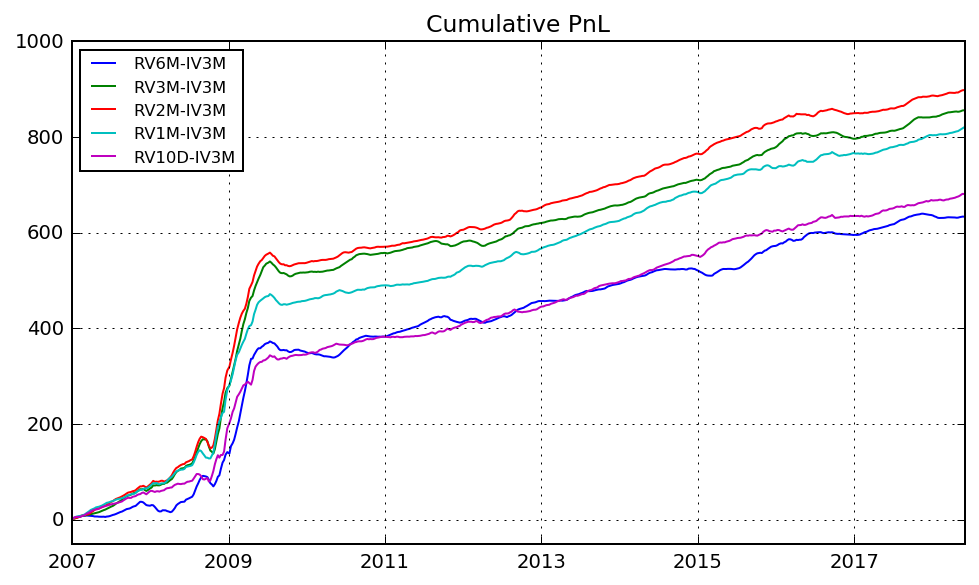

In [14]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV6M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV3M-IV3M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV2M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='RV1M-IV3M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='RV10D-IV3M')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [15]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
RV6M-IV3M,0.774847,1.1019,2.84419,0.69913,-7.17379,-0.135444,0.692719,1.59799,19.8669
RV3M-IV3M,0.93456,1.48878,3.18605,0.845217,-11.1676,0.361251,0.867718,1.62849,21.9723
RV2M-IV3M,0.958857,1.56219,3.25845,0.831304,-8.01126,0.328178,0.97949,1.7136,21.9944
RV1M-IV3M,1.01333,1.42678,2.81602,0.850435,-5.17911,0.324914,0.983487,1.68252,25.3106
RV10D-IV3M,0.925577,1.18421,2.55885,0.793043,-7.32413,0.132276,0.918635,1.66808,25.0698


In [16]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
RV6M-IV3M,0.572647,2.24254,4.08404,0.66222,0.593349,0.895335,0.705024,0.578949,0.988818,0.454318,0.835968
RV3M-IV3M,1.27747,4.19588,4.74669,0.815437,0.437906,0.807699,0.729826,1.0708,1.33086,0.353984,0.905765
RV2M-IV3M,1.43659,4.77247,4.41653,0.672345,0.697305,0.929084,0.980786,1.26596,1.31584,0.346074,0.732495
RV1M-IV3M,1.38031,4.01304,3.67454,0.628944,0.633143,0.88641,1.15656,1.21679,0.96444,0.635111,0.750924
RV10D-IV3M,1.16883,2.62982,3.02695,0.740226,0.503223,0.725212,1.04154,1.09876,1.02709,0.611846,0.667472


## RV-past IV

In [17]:
pnl1 = backtest3m(stock_rv6m - stock_iv3m.shift(63))
pnl2 = backtest3m(stock_rv3m - stock_iv3m.shift(63))
pnl3 = backtest3m(stock_rv2m - stock_iv3m.shift(63))
pnl4 = backtest3m(stock_rv1m - stock_iv3m.shift(63))
pnl5 = backtest3m(stock_rv10d - stock_iv3m.shift(63))

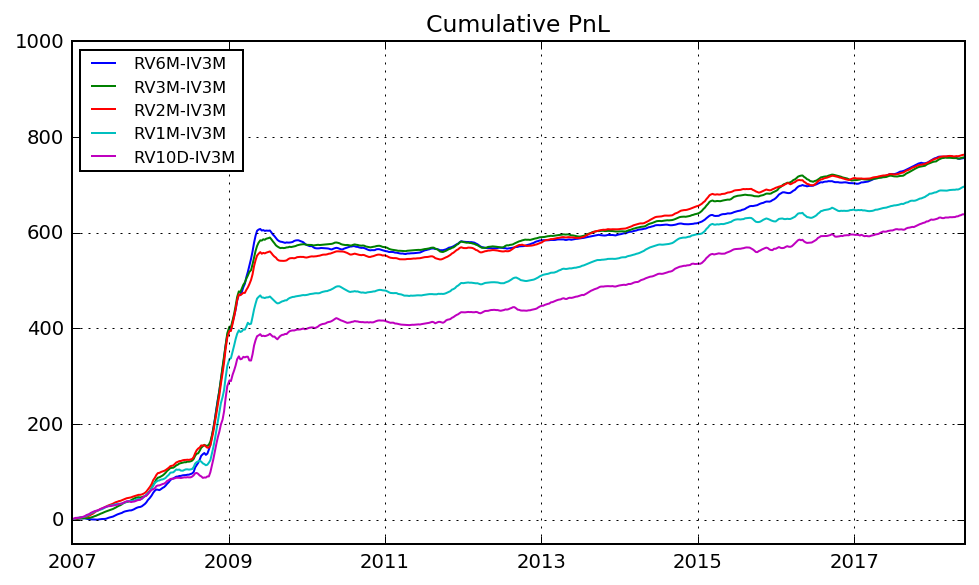

In [18]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV6M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV3M-IV3M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV2M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='RV1M-IV3M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='RV10D-IV3M')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [19]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
RV6M-IV3M,0.69769,1.31526,3.77033,0.707826,-4.50159,-0.141571,0.523752,1.34588,25.2287
RV3M-IV3M,0.730485,1.31776,3.6079,0.711304,-4.33597,-0.15018,0.601084,1.40481,25.8057
RV2M-IV3M,0.742458,1.32717,3.57508,0.754783,-4.10018,0.0150805,0.700503,1.47357,27.7331
RV1M-IV3M,0.758369,1.21128,3.19443,0.763478,-4.27732,0.0438123,0.697467,1.44269,25.4566
RV10D-IV3M,0.73616,1.11043,3.01683,0.74087,-7.74113,-0.0343939,0.740115,1.43609,27.0049


In [20]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['RV6M-IV3M','RV3M-IV3M','RV2M-IV3M','RV1M-IV3M','RV10D-IV3M'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
RV6M-IV3M,0.898312,6.79124,3.70884,-0.243254,0.395493,0.0317098,0.249935,0.462627,1.03352,0.61995,0.961321
RV3M-IV3M,1.18353,6.58882,3.62587,-0.0950287,0.230772,0.178284,0.240285,0.733085,0.937124,0.451564,0.734118
RV2M-IV3M,1.34864,6.24185,3.2788,0.0910597,0.33846,0.173332,0.57172,0.956536,0.759737,0.40089,0.731952
RV1M-IV3M,1.16596,5.23581,2.91349,0.186208,0.315085,0.277485,0.744331,0.997726,0.529261,0.494529,0.666728
RV10D-IV3M,1.15287,4.40937,2.34737,0.342931,0.353905,0.233743,0.865373,0.900736,0.622537,0.594506,0.628629


## RV - IV Bollinger

In [21]:
stock_rviv = stock_rv3m - stock_iv3m

pnl1 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 63) / pd.rolling_mean(stock_rviv, 63)))
pnl2 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 21) / pd.rolling_mean(stock_rviv, 21)))
pnl3 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 10) / pd.rolling_mean(stock_rviv, 10)))
pnl4 = backtest3m((stock_rviv - pd.rolling_mean(stock_rviv, 5) / pd.rolling_mean(stock_rviv, 5)))

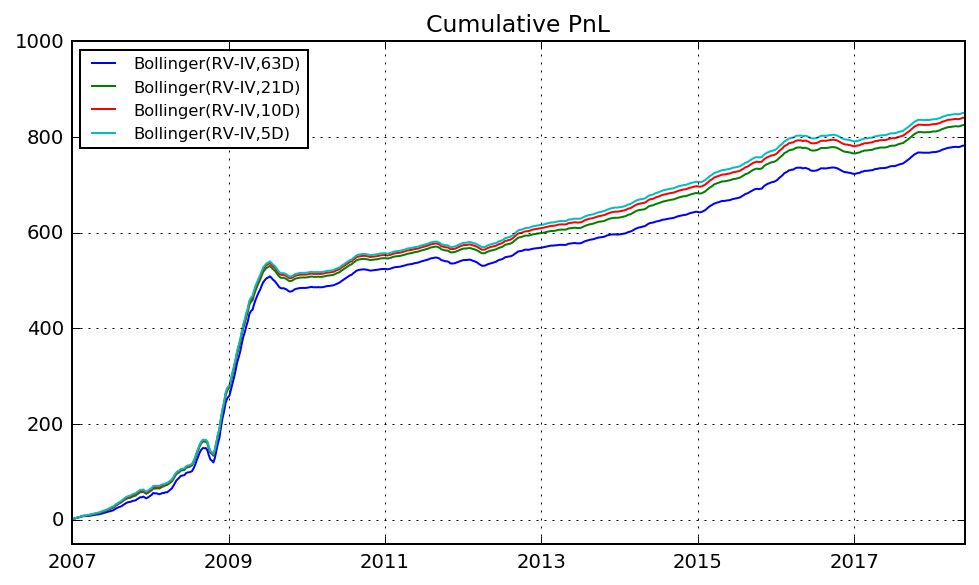

In [22]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Bollinger(RV-IV,63D)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Bollinger(RV-IV,21D)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='Bollinger(RV-IV,10D)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='Bollinger(RV-IV,5D)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [23]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['Bollinger(RV-IV,63D)','Bollinger(RV-IV,21D)','Bollinger(RV-IV,10D)','Bollinger(RV-IV,5D)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"Bollinger(RV-IV,63D)",0.870083,1.36038,3.12701,0.826087,-11.1676,0.223879,0.767225,1.48082,21.4789
"Bollinger(RV-IV,21D)",0.90893,1.43536,3.15835,0.84,-11.1676,0.295342,0.800185,1.61632,21.8679
"Bollinger(RV-IV,10D)",0.918608,1.4618,3.18265,0.84,-11.1676,0.337164,0.830428,1.62806,21.9723
"Bollinger(RV-IV,5D)",0.926884,1.47955,3.19254,0.841739,-11.1676,0.361251,0.842309,1.62377,21.9723


In [24]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['Bollinger(RV-IV,63D)','Bollinger(RV-IV,21D)','Bollinger(RV-IV,10D)','Bollinger(RV-IV,5D)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
"Bollinger(RV-IV,63D)",0.973871,4.08613,4.5271,0.789699,0.338816,0.541457,0.549799,0.950073,1.26252,0.297565,0.894579
"Bollinger(RV-IV,21D)",1.15967,4.22484,4.6327,0.80328,0.367553,0.674477,0.642361,1.02697,1.31326,0.314863,0.90344
"Bollinger(RV-IV,10D)",1.21008,4.2422,4.68548,0.811303,0.380984,0.735752,0.692699,1.05606,1.31375,0.333885,0.904569
"Bollinger(RV-IV,5D)",1.25537,4.22668,4.72747,0.815212,0.39857,0.778728,0.724989,1.07432,1.31908,0.344186,0.903389


## Vol Skew

In [25]:
pnl1 = backtest3m((stock_iv1m75delta - stock_iv1m25delta))
pnl2 = backtest3m((stock_iv1m75delta - stock_iv1m25delta) / stock_iv1m50delta)
pnl3 = backtest3m((stock_iv2m75delta - stock_iv2m25delta))
pnl4 = backtest3m((stock_iv2m75delta - stock_iv2m25delta) / stock_iv1m50delta)

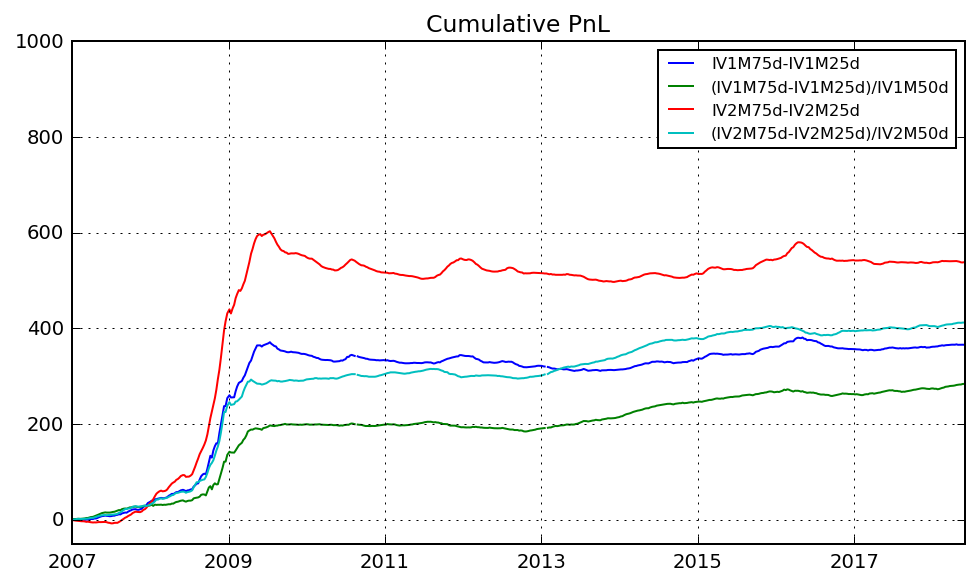

In [26]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV1M75d-IV1M25d')
plt.plot(pnl2[pnl2!=0].cumsum(), label='(IV1M75d-IV1M25d)/IV1M50d')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV2M75d-IV2M25d')
plt.plot(pnl4[pnl4!=0].cumsum(), label='(IV2M75d-IV2M25d)/IV2M50d')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper right', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [27]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV1M75d-IV1M25d','(IV1M75d-IV1M25d)/IV1M50d','IV2M75d-IV2M25d','(IV2M75d-IV2M25d)/IV2M50d'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
IV1M75d-IV1M25d,0.474451,0.656572,2.76771,0.570662,-4.71068,-0.509511,0.138154,0.857913,21.4156
(IV1M75d-IV1M25d)/IV1M50d,0.600323,0.509844,1.69857,0.649374,-6.65172,-0.212961,0.367143,0.855195,14.1716
IV2M75d-IV2M25d,0.474405,0.936381,3.9476,0.511304,-8.63495,-0.710297,0.0351802,1.33097,30.2517
(IV2M75d-IV2M25d)/IV2M50d,0.656504,0.741394,2.25861,0.707885,-5.71298,-0.092978,0.432059,1.02804,22.2608


In [28]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['IV1M75d-IV1M25d','(IV1M75d-IV1M25d)/IV1M50d','IV2M75d-IV2M25d','(IV2M75d-IV2M25d)/IV2M50d'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
IV1M75d-IV1M25d,0.757334,4.43022,1.93986,-0.242974,0.216803,-0.473078,-0.171831,0.441414,0.511693,-0.101971,0.0862384
(IV1M75d-IV1M25d)/IV1M50d,0.605284,2.1608,1.36307,-0.0184961,-0.113442,-0.0717766,0.523347,0.637268,0.402562,-0.0850928,0.233049
IV2M75d-IV2M25d,0.671916,7.94205,2.30046,-0.636675,0.585412,-0.605753,-0.324722,0.314528,0.5716,-0.0296693,-0.112765
(IV2M75d-IV2M25d)/IV2M50d,0.635957,4.22513,1.17192,0.234879,-0.137165,0.0578634,0.881478,0.754586,0.474662,-0.175567,0.190219


## Term Structure

In [29]:
pnl1 = backtest3m(- stock_iv3m + stock_iv12m)
pnl2 = backtest3m(- stock_iv6m + stock_iv12m)
pnl3 = backtest3m(- stock_iv3m + stock_iv6m)
pnl4 = backtest3m(- stock_iv1m + stock_iv3m)
pnl5 = backtest3m(- stock_iv2m + stock_iv3m)

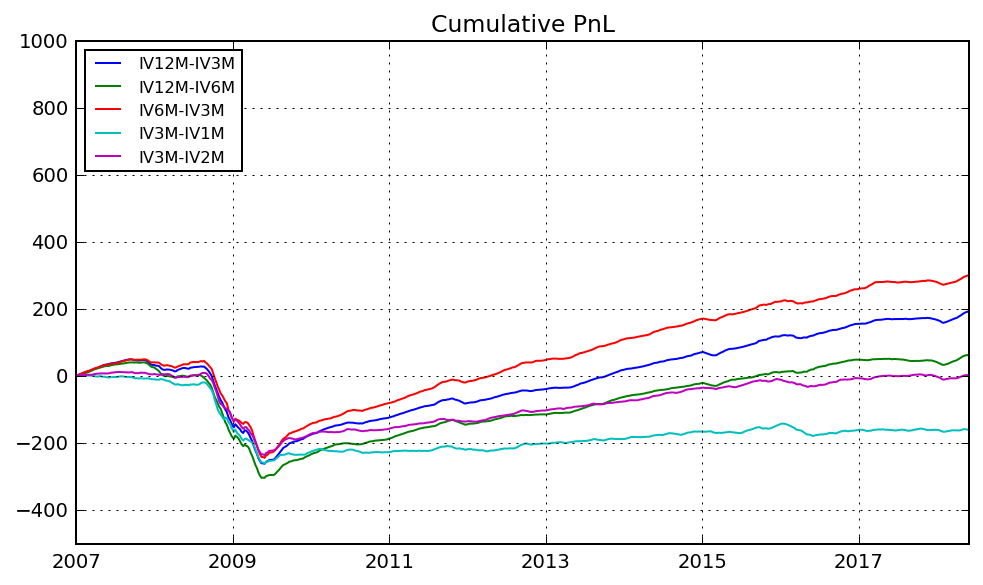

In [30]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-IV3M')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-IV6M')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV6M-IV3M')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV3M-IV1M')
plt.plot(pnl5[pnl5!=0].cumsum(), label='IV3M-IV2M')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [31]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5], ['IV12M-IV3M','IV12M-IV6M','IV6M-IV3M','IV3M-IV1M','IV3M-IV2M'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
IV12M-IV3M,0.238665,0.337207,2.82578,0.772174,-14.6136,0.13605,0.926195,1.56282,9.27854
IV12M-IV6M,0.0798571,0.111431,2.79077,0.730435,-14.2824,-0.0722323,0.671852,1.40996,9.4328
IV6M-IV3M,0.355589,0.52389,2.9466,0.786087,-18.991,0.213941,1.07557,1.74663,9.58217
IV3M-IV1M,-0.230385,-0.278863,2.42084,0.521739,-17.9096,-0.68725,0.0592743,0.78951,6.21012
IV3M-IV2M,0.00449697,0.00541492,2.40825,0.653913,-15.3061,-0.393274,0.405728,1.04587,6.60808


In [32]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5], ['IV3M-IV12M','IV6M-IV12M','IV1M-IV3M','IV1M-IV12M','IV1M-IV2M'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
IV3M-IV12M,0.653105,-3.50517,-0.634448,1.0047,0.848261,0.849692,1.14073,1.04114,0.946664,0.73872,0.262333
IV6M-IV12M,0.505098,-4.09786,-1.06377,0.928754,0.839954,0.612826,1.02013,0.826246,0.629391,0.766171,-0.115149
IV1M-IV3M,0.812888,-3.28149,-0.382807,1.23061,1.23763,1.322,1.2269,1.21985,1.02473,0.737177,0.447101
IV1M-IV12M,-0.179118,-2.91783,-1.37983,-0.0329683,0.144921,0.379226,0.265419,0.436228,0.438222,-0.355233,0.0195281
IV1M-IV2M,0.13141,-2.58829,-0.968047,0.293626,0.436965,0.655487,0.536223,0.806156,0.491377,0.0788326,0.124779


## IV Momentum

In [67]:
pnl1 = backtest3m(-(stock_iv3m - stock_iv3m.shift(63)) / stock_iv3m.shift(63))
pnl2 = backtest3m(-(stock_iv3m - stock_iv3m.shift(21)) / stock_iv3m.shift(21))
pnl3 = backtest3m(-(stock_iv3m - stock_iv3m.shift(10)) / stock_iv3m.shift(10))
pnl4 = backtest3m(-(stock_iv3m - stock_iv3m.shift(5)) / stock_iv3m.shift(5))

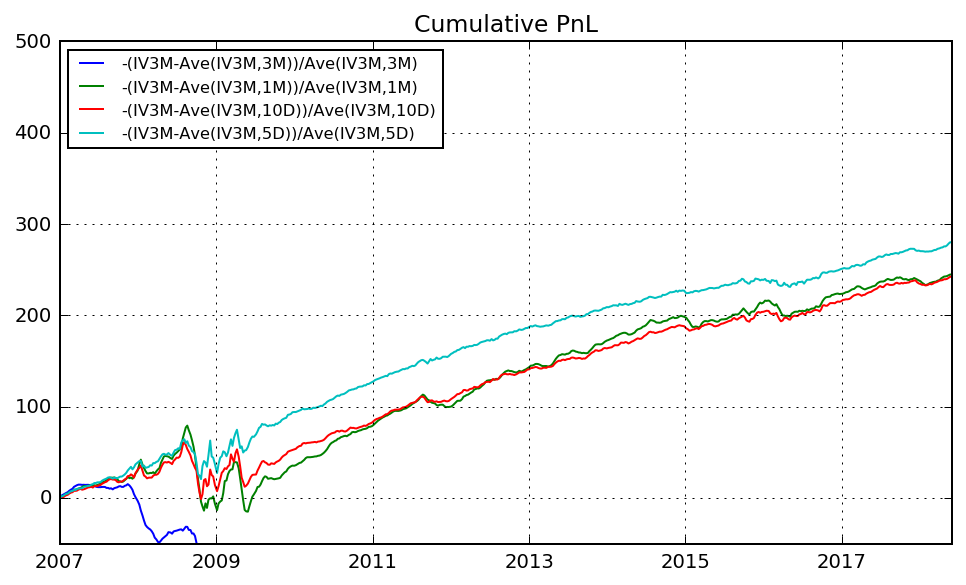

In [68]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [69]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)','-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)','-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)', '-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)",-0.102703,-0.15796,3.07606,0.615652,-21.5767,-0.513969,0.395994,1.07455,8.9595
"-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)",0.350492,0.425469,2.42784,0.711304,-14.2334,-0.1427,0.585822,1.28036,13.0915
"-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)",0.376193,0.422203,2.24461,0.72,-14.1753,-0.144714,0.520627,1.15528,16.4785
"-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)",0.433234,0.486924,2.24785,0.716522,-17.4876,-0.0941817,0.508523,1.14456,15.8904


In [70]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)','-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)','-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)', '-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
"-(IV3M-Ave(IV3M,3M))/Ave(IV3M,3M)",-0.0602356,-4.80893,0.0834369,1.00362,0.602322,0.848367,0.391002,0.345765,0.00242976,-0.0387193,-0.247383
"-(IV3M-Ave(IV3M,1M))/Ave(IV3M,1M)",0.586754,-0.724913,0.815431,0.866531,0.419942,0.84684,0.596813,0.52065,0.304416,0.191299,0.294048
"-(IV3M-Ave(IV3M,10D))/Ave(IV3M,10D)",0.605329,-0.333579,0.763762,0.585375,0.476143,0.687772,0.45454,0.486863,0.308338,0.229568,0.390955
"-(IV3M-Ave(IV3M,5D))/Ave(IV3M,5D)",0.758628,-0.0308761,1.11693,0.652,0.574205,0.612867,0.450452,0.359341,0.231779,0.238394,0.402957


## IV Mean Reverse

In [71]:
pnl1 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 63) / pd.rolling_mean(stock_iv3m, 63)))
pnl2 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 21) / pd.rolling_mean(stock_iv3m, 21)))
pnl3 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 10) / pd.rolling_mean(stock_iv3m, 10)))
pnl4 = backtest3m(-(stock_iv3m - pd.rolling_mean(stock_iv3m, 5) / pd.rolling_mean(stock_iv3m, 5)))

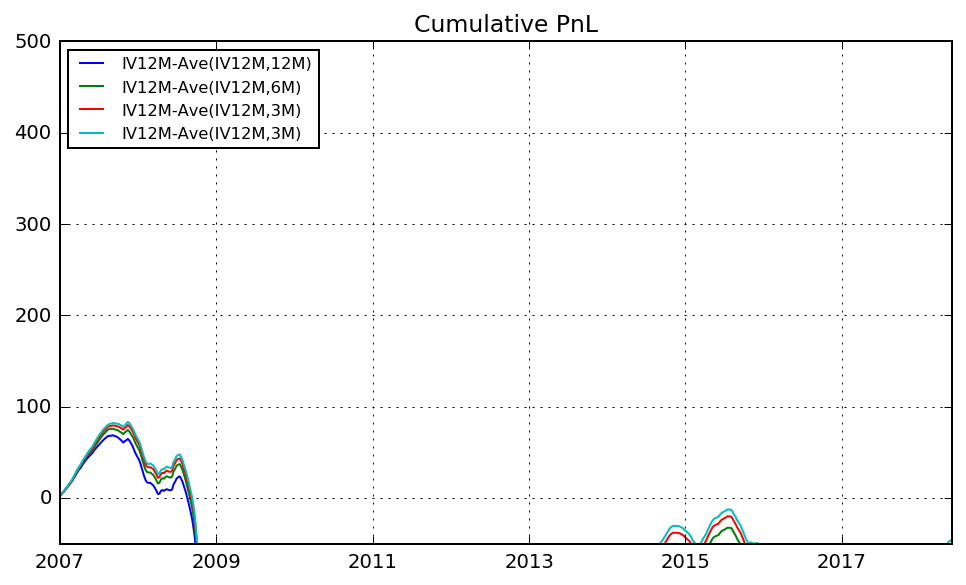

In [72]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-Ave(IV12M,12M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-Ave(IV12M,6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [73]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)', '123'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"IV12M-Ave(IV12M,12M)",-0.062821,-0.148174,4.71734,0.666087,-28.7626,-1.04119,1.24765,2.07709,13.154
"IV12M-Ave(IV12M,6M)",-0.0482785,-0.115995,4.80524,0.666087,-29.5372,-1.00509,1.24813,2.13732,13.154
"IV12M-Ave(IV12M,3M)",-0.0390072,-0.0938136,4.81007,0.666087,-29.5372,-0.980466,1.24813,2.15759,13.154
123,-0.0330672,-0.07954,4.81082,0.666087,-29.5372,-0.980466,1.26476,2.20674,13.147


In [74]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
"IV12M-Ave(IV12M,12M)",0.876209,-7.46501,-0.236619,1.5353,-1.04306,1.1917,2.13599,1.501,-0.494273,-0.568733,0.402599
"IV12M-Ave(IV12M,6M)",1.09195,-7.5564,-0.234805,1.5613,-1.02292,1.22272,2.20835,1.58602,-0.465535,-0.590153,0.400913
"IV12M-Ave(IV12M,3M)",1.20475,-7.54394,-0.206252,1.57375,-1.0157,1.22157,2.24349,1.61805,-0.459104,-0.58429,0.400553


## RV Momentum

In [75]:
pnl1 = backtest3m((stock_rv3m - stock_rv3m.shift(63)) )
pnl2 = backtest3m((stock_rv3m - stock_rv3m.shift(21)))
pnl3 = backtest3m((stock_rv3m - stock_rv3m.shift(10)))
pnl4 = backtest3m((stock_rv3m - stock_rv3m.shift(5)))

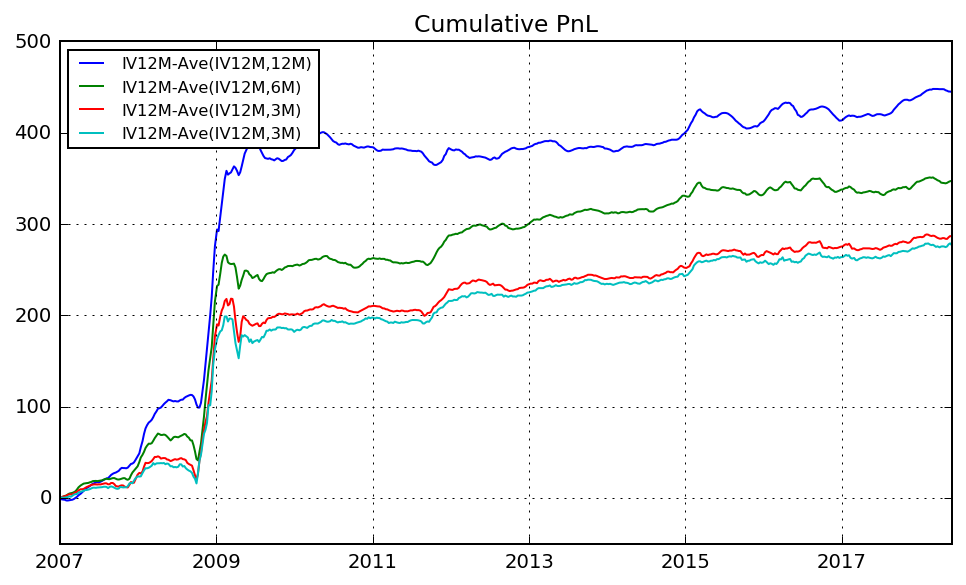

In [76]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-Ave(IV12M,12M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-Ave(IV12M,6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [77]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)', '123'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"IV12M-Ave(IV12M,12M)",0.486422,0.773327,3.17965,0.608696,-5.55422,-0.434177,0.348672,1.07069,27.916
"IV12M-Ave(IV12M,6M)",0.414624,0.604065,2.9138,0.62087,-13.0736,-0.398296,0.344286,0.975704,26.1306
"IV12M-Ave(IV12M,3M)",0.356,0.498068,2.79813,0.573913,-15.1818,-0.439525,0.195629,0.914548,24.9953
123,0.355115,0.481442,2.71146,0.615652,-13.2065,-0.406702,0.251551,0.919587,29.0975


In [78]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
"IV12M-Ave(IV12M,12M)",0.896166,4.59787,2.06758,0.0628976,-0.0208834,0.0168441,-0.0279689,0.328972,0.259297,0.0220543,0.538536
"IV12M-Ave(IV12M,6M)",0.679117,3.61058,0.776452,0.150437,0.502984,0.236355,0.243363,0.387726,0.0255679,0.106708,0.174854
"IV12M-Ave(IV12M,3M)",0.500314,3.02811,0.467635,0.186367,0.369053,0.0959408,0.12681,0.249763,0.267968,0.185531,0.207621


## RV-IV Momentum ?

In [79]:
stock_rviv = stock_rv3m - stock_iv3m.shift(63)
pnl1 = backtest3m((stock_rviv - stock_rviv.shift(63)) / stock_rviv.shift(63))
pnl2 = backtest3m((stock_rviv - stock_rviv.shift(21)) / stock_rviv.shift(21))
pnl3 = backtest3m((stock_rviv - stock_rviv.shift(10)) / stock_rviv.shift(10))
pnl4 = backtest3m((stock_rviv - stock_rviv.shift(5)) / stock_rviv.shift(5))

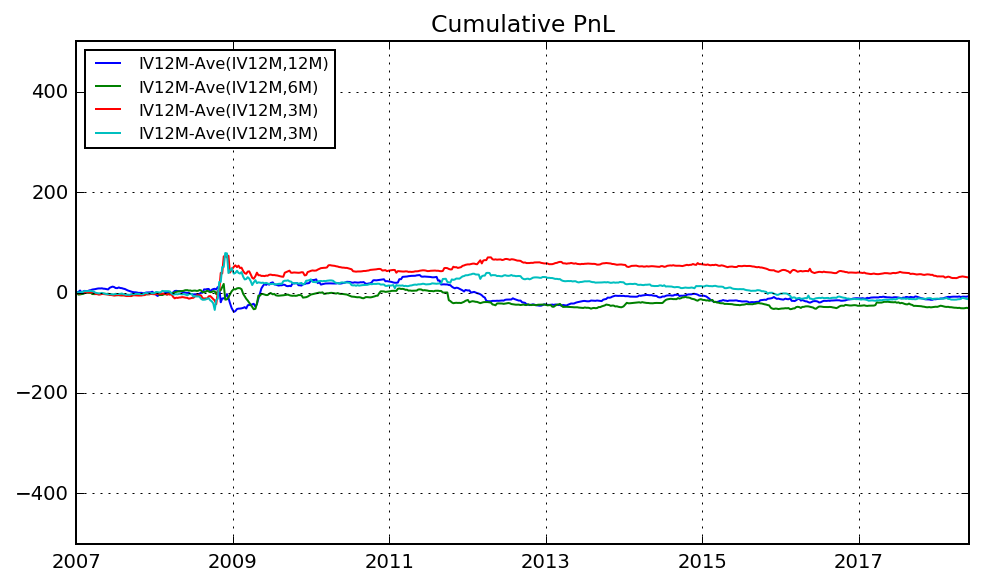

In [80]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='IV12M-Ave(IV12M,12M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='IV12M-Ave(IV12M,6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='IV12M-Ave(IV12M,3M)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-500, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [81]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)', '123'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"IV12M-Ave(IV12M,12M)",-0.0111837,-0.0127593,2.28177,0.525217,-29.5674,-0.551216,0.0498962,0.664842,11.0019
"IV12M-Ave(IV12M,6M)",-0.0495125,-0.0543865,2.19688,0.486957,-31.3315,-0.562122,-0.0369137,0.549211,15.2579
"IV12M-Ave(IV12M,3M)",0.0335316,0.0520613,3.10521,0.46087,-33.5754,-0.617892,-0.0860448,0.52545,35.299
123,-0.0137901,-0.0232842,3.37694,0.48,-39.1117,-0.624974,-0.0318418,0.490908,33.7096


In [82]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['IV12M-Ave(IV12M,12M)','IV12M-Ave(IV12M,6M)','IV12M-Ave(IV12M,3M)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
"IV12M-Ave(IV12M,12M)",-0.0381089,-0.580961,1.07149,-0.0319994,-0.339392,-0.575297,0.332403,0.00472246,-0.131469,0.03465,-0.0406368
"IV12M-Ave(IV12M,6M)",-0.0394408,0.0893822,-0.128049,0.123092,-0.37187,-0.149845,-0.0724084,0.288372,-0.374639,0.118686,-0.0380553
"IV12M-Ave(IV12M,3M)",-0.0689182,0.976459,-0.0419692,0.00657537,0.232217,0.0559677,-0.0545424,0.0276555,-0.269129,-0.0597414,-0.132195


## RV Momentum

In [83]:
pnl1 = backtest3m(stock_rv3m - stock_rv3m.shift(63))
pnl2 = backtest3m(stock_rv3m - stock_rv3m.shift(21))
pnl3 = backtest3m(stock_rv3m - stock_rv3m.shift(10))

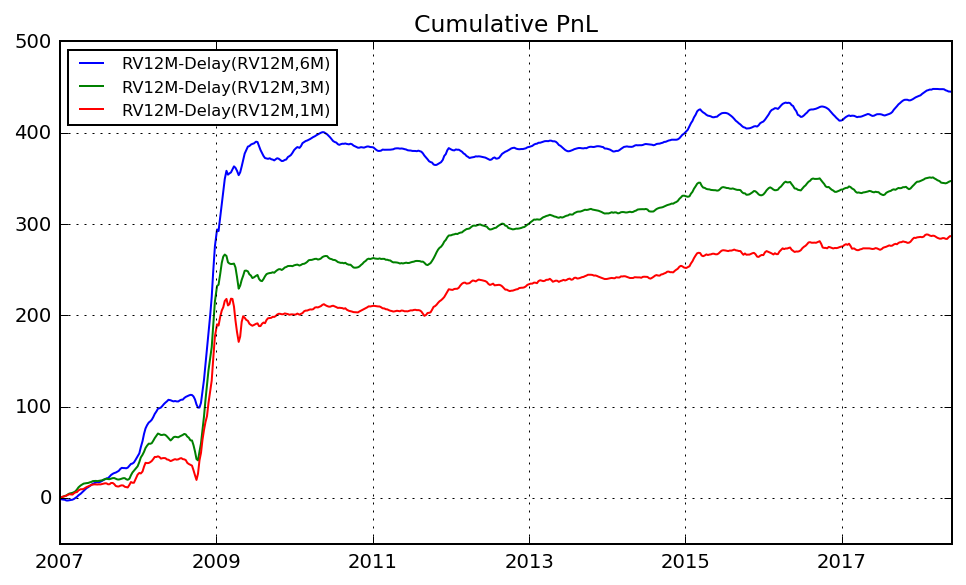

In [84]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='RV12M-Delay(RV12M,6M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='RV12M-Delay(RV12M,3M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='RV12M-Delay(RV12M,1M)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 500)
plt.savefig('h:/rv-iv.png')
plt.show()

In [85]:
performance = report_table([pnl1,pnl2,pnl3], ['RV12M-Delay(RV12M,6M)','RV12M-Delay(RV12M,3M)','RV12M-Delay(RV12M,1M)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
"RV12M-Delay(RV12M,6M)",0.486422,0.773327,3.17965,0.608696,-5.55422,-0.434177,0.348672,1.07069,27.916
"RV12M-Delay(RV12M,3M)",0.414624,0.604065,2.9138,0.62087,-13.0736,-0.398296,0.344286,0.975704,26.1306
"RV12M-Delay(RV12M,1M)",0.356,0.498068,2.79813,0.573913,-15.1818,-0.439525,0.195629,0.914548,24.9953


In [86]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3], ['RV12M-Delay(RV12M,6M)','RV12M-Delay(RV12M,3M)','RV12M-Delay(RV12M,1M)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
"RV12M-Delay(RV12M,6M)",0.896166,4.59787,2.06758,0.0628976,-0.0208834,0.0168441,-0.0279689,0.328972,0.259297,0.0220543,0.538536
"RV12M-Delay(RV12M,3M)",0.679117,3.61058,0.776452,0.150437,0.502984,0.236355,0.243363,0.387726,0.0255679,0.106708,0.174854
"RV12M-Delay(RV12M,1M)",0.500314,3.02811,0.467635,0.186367,0.369053,0.0959408,0.12681,0.249763,0.267968,0.185531,0.207621


## Cash Bollinger

In [53]:
pnl1 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 63)) / pd.rolling_std(stock_prices, 63)))
pnl2 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 126)) / pd.rolling_std(stock_prices, 126)))
pnl3 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 252)) / pd.rolling_std(stock_prices, 252)))
pnl4 = backtest3m(np.abs((stock_prices - pd.rolling_mean(stock_prices, 378)) / pd.rolling_std(stock_prices, 378)))

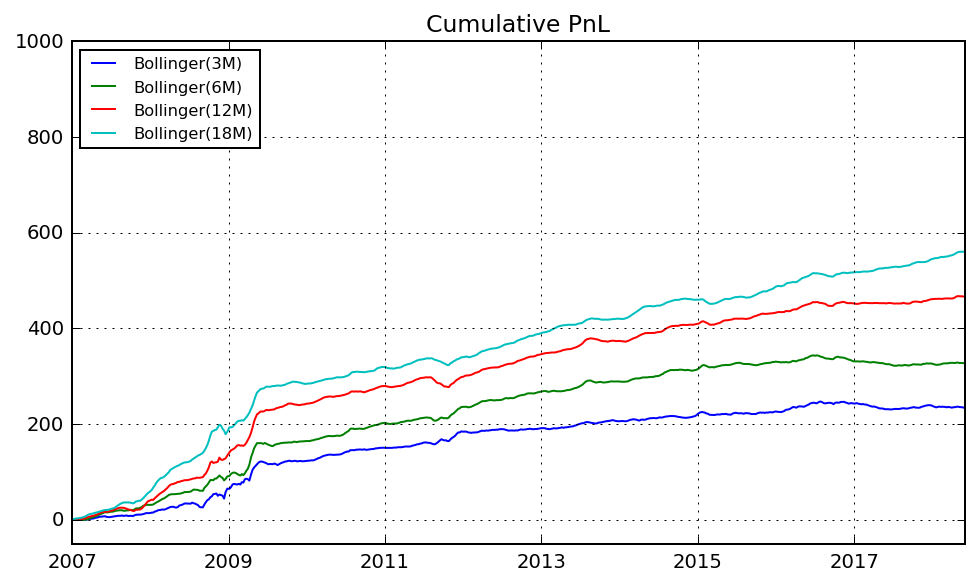

In [54]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Bollinger(3M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Bollinger(6M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='Bollinger(12M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='Bollinger(18M)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [55]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['Bollinger(3M)','Bollinger(6M)','Bollinger(12M)','Bollinger(18M)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Bollinger(3M),0.537744,0.40699,1.51369,0.615652,-6.22631,-0.319717,0.250214,0.821852,13.4804
Bollinger(6M),0.760277,0.568864,1.49647,0.673043,-5.11776,-0.170849,0.384662,1.02102,15.5606
Bollinger(12M),1.02615,0.811136,1.58094,0.754783,-3.99558,0.016385,0.615464,1.31592,12.3293
Bollinger(18M),1.18954,0.974543,1.63852,0.8,-7.36627,0.194421,0.765245,1.47609,10.6662


In [56]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['Bollinger(3M)','Bollinger(6M)','Bollinger(12M)','Bollinger(18M)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Bollinger(3M),0.271641,1.02094,1.13984,0.549195,0.680539,0.120019,0.300356,0.253337,0.1529,0.332288,-0.0767231
Bollinger(6M),0.609655,1.18662,1.45049,0.760516,0.65965,0.6374,0.426398,0.487709,0.33692,0.00868008,-0.0895864
Bollinger(12M),0.786169,1.87918,2.12758,0.739551,0.369725,0.942455,0.562293,0.706276,0.464229,0.389628,0.174414
Bollinger(18M),1.14943,2.50409,1.96665,0.701481,0.404364,0.993882,0.607408,0.798766,0.532057,0.599692,0.549642


## Cash RSI

In [57]:
stock_delta1 = stock_prices - stock_prices.shift(1)
stock_gain = stock_delta1[stock_delta1>0]
stock_loss = np.abs(stock_delta1[stock_delta1<0])

def stock_rsi(N):
    return 100 * 1 / (1 + pd.rolling_mean(stock_loss, N, min_periods=0) / pd.rolling_mean(stock_gain, N, min_periods=0))

In [58]:
pnl1 = backtest3m(-stock_rsi(21))
pnl2 = backtest3m(-stock_rsi(63))
pnl3 = backtest3m(-stock_rsi(126))
pnl4 = backtest3m(-stock_rsi(252))

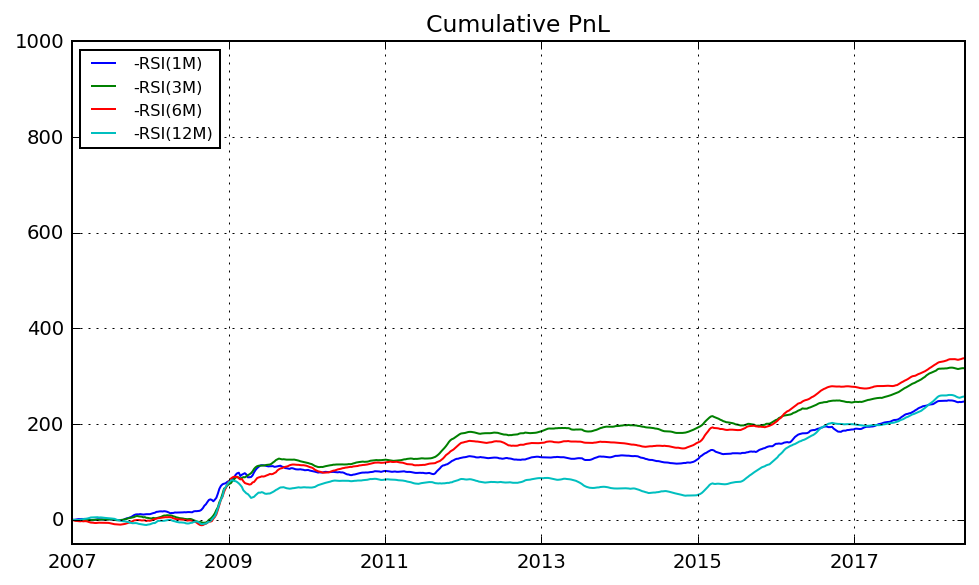

In [59]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='-RSI(1M)')
plt.plot(pnl2[pnl2!=0].cumsum(), label='-RSI(3M)')
plt.plot(pnl3[pnl3!=0].cumsum(), label='-RSI(6M)')
plt.plot(pnl4[pnl4!=0].cumsum(), label='-RSI(12M)')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-50, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [60]:
performance = report_table([pnl1,pnl2,pnl3,pnl4], ['-RSI(1M)','-RSI(3M)','-RSI(6M)','-RSI(12M)'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
-RSI(1M),0.614619,0.429761,1.39846,0.605217,-6.93955,-0.29636,0.217654,0.942099,10.0828
-RSI(3M),0.756067,0.55074,1.45686,0.634783,-2.10593,-0.299312,0.295814,1.1281,11.2526
-RSI(6M),0.737721,0.587303,1.59221,0.6,-4.75357,-0.298093,0.291903,1.09909,10.8905
-RSI(12M),0.559059,0.447875,1.60225,0.593043,-7.11815,-0.383847,0.188144,0.979755,13.735


In [61]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4], ['-RSI(1M)','-RSI(3M)','-RSI(6M)','-RSI(12M)'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
-RSI(1M),0.225606,1.35125,0.481899,-0.0368436,0.549372,0.0344105,0.0554003,-0.1814,0.662944,0.601811,1.04832
-RSI(3M),0.0554356,1.3758,0.932175,0.123774,1.09714,0.0745025,0.238264,-0.0919811,0.329231,0.748999,1.2297
-RSI(6M),-0.0454061,1.52299,0.76246,0.131006,0.825057,-0.00725149,0.0029879,-0.00588181,0.862143,1.47812,0.819663
-RSI(12M),-0.189043,1.6667,-0.123539,0.323368,0.0310287,0.0368259,-0.423854,-0.286258,1.48477,1.45401,0.902304


## Fundamentals

In [62]:
pnl1 = backtest3m(stock_asset_per_equity)
pnl2 = backtest3m(stock_asset_per_marketcap)
pnl3 = backtest3m(-stock_eps)
pnl4 = backtest3m(-stock_roe)
pnl5 = backtest3m(stock_cps)
pnl6 = backtest3m(stock_cpx_per_marketcap)
pnl7 = backtest3m(stock_dps)

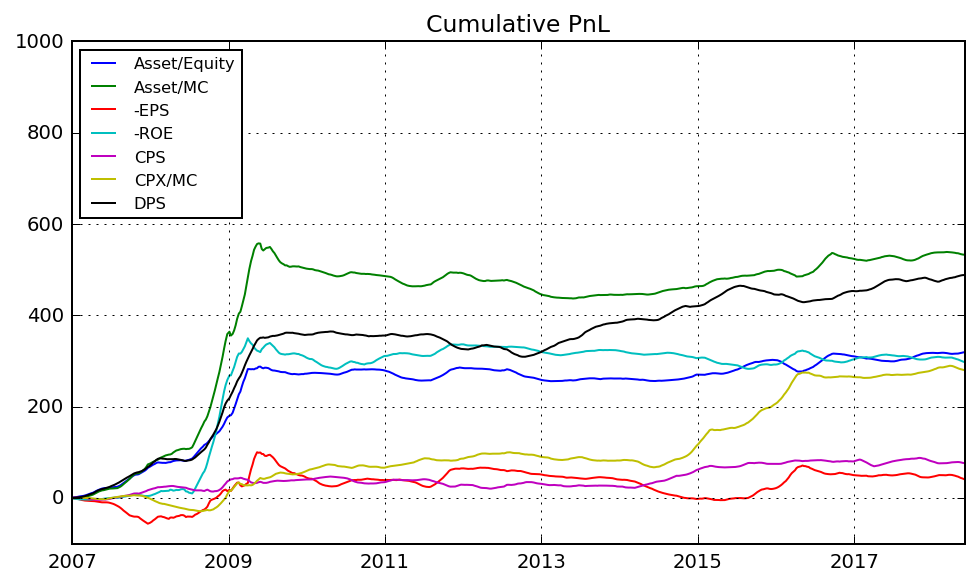

In [63]:
plt.figure(figsize=(8, 4.5))
plt.plot(pnl1[pnl1!=0].cumsum(), label='Asset/Equity')
plt.plot(pnl2[pnl2!=0].cumsum(), label='Asset/MC')
plt.plot(pnl3[pnl3!=0].cumsum(), label='-EPS')
plt.plot(pnl4[pnl4!=0].cumsum(), label='-ROE')
plt.plot(pnl5[pnl5!=0].cumsum(), label='CPS')
plt.plot(pnl6[pnl6!=0].cumsum(), label='CPX/MC')
plt.plot(pnl7[pnl7!=0].cumsum(), label='DPS')
plt.xlim(pd.to_datetime('20070101'), pd.to_datetime('20180601'))
plt.title("Cumulative PnL")
plt.grid(True)
plt.legend(loc='upper left', frameon=True, fontsize='small')
plt.ylim(-100, 1000)
plt.savefig('h:/rv-iv.png')
plt.show()

In [64]:
performance = report_table([pnl1,pnl2,pnl3,pnl4,pnl5,pnl6,pnl7], ['Asset/Equity','Asset/MC','-EPS','-ROE','CPS','CPX/MC','DPS'])
performance

,Sharpe Ratio,PnL Mean,PnL Std,Hit Rate,PnL Min,PnL 25%Perc,PnL Median,PnL 75%Perc,PnL Max
Asset/Equity,0.632907,0.555111,1.75416,0.573913,-2.75693,-0.332511,0.169914,1.04623,11.4592
Asset/MC,0.548422,0.926546,3.37895,0.603478,-11.7547,-0.514322,0.256765,1.11403,19.2976
-EPS,0.0746517,0.0714706,1.91477,0.396522,-5.89664,-0.801703,-0.214819,0.556077,15.4241
-ROE,0.367008,0.51774,2.82141,0.474783,-6.14946,-0.625908,-0.0539768,0.635222,20.1246
CPS,0.320177,0.132791,0.829488,0.57913,-2.93042,-0.32673,0.126236,0.604947,4.8453
CPX/MC,0.682206,0.486981,1.42766,0.57913,-2.91435,-0.366711,0.21586,0.923888,7.749
DPS,0.875033,0.849123,1.94078,0.678261,-2.77745,-0.332629,0.54988,1.47711,10.9148


In [65]:
pnl_mean_yearly = annual_pnl_mean([pnl1,pnl2,pnl3,pnl4,pnl5,pnl6,pnl7], ['Asset/Equity','Asset/MC','-EPS','-ROE','CPS','CPX/MC','DPS'])
pnl_mean_yearly

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Asset/Equity,1.34352,2.1538,1.88228,0.144416,0.115246,-0.516518,0.0446038,0.170777,0.62527,0.165266,0.148374
Asset/MC,1.47475,5.67494,2.80971,-0.321789,0.139437,-0.919902,-0.0468355,0.379303,0.685342,0.505194,0.244475
-EPS,-1.06829,1.38937,0.575548,-0.106334,0.513895,-0.256016,-0.228736,-0.851695,0.46505,0.573128,-0.083117
-ROE,0.0954663,5.06706,0.96068,0.072116,0.512465,-0.313045,0.0331754,-0.325778,-0.274796,0.225036,0.0790663
CPS,0.360909,0.35421,0.0853962,-0.11955,-0.10742,0.0445004,-0.126601,0.723553,0.262485,0.110429,0.0135458
CPX/MC,-0.0281583,0.182841,1.00897,0.140394,0.394775,0.0952979,-0.170847,0.641917,1.81339,1.16573,0.286688
DPS,1.39106,2.84379,2.82985,-0.0344077,-0.585464,-0.15947,1.30074,0.699856,0.501675,0.156639,0.498814
